### Resumen de la metadata de las capas de datos (Global Solar Atlas 2.0 – Colombia)

Los archivos provienen del **Global Solar Atlas 2.0**, desarrollado por **Solargis** y el **Banco Mundial (ESMAP)**, con información satelital procesada entre **1994 y 2018**. Cada capa está en formato **GeoTIFF** y corresponde a un promedio de largo plazo, con resolución espacial de entre **9 y 120 arc-segundos** (dependiendo de la variable).

Los datasets disponibles son:

* **DIF.tif** → Irradiación horizontal difusa (kWh/m²).
* **DNI.tif** → Irradiación normal directa (kWh/m²).
* **GHI.tif** → Irradiación global horizontal (kWh/m²).
* **GTI.tif** → Irradiación global en el ángulo óptimo de inclinación (kWh/m²).
* **OPTA.tif** → Ángulo de inclinación óptimo para módulos FV (grados).
* **PVOUT.tif** → Producción fotovoltaica potencial (kWh/kWp).
* **TEMP.tif** → Temperatura media del aire (°C).

**Uso y propósito**:

* DIF, DNI y GHI → caracterizan la disponibilidad de radiación solar en distintas condiciones.
* GTI y OPTA → permiten optimizar la captación de energía al definir la inclinación de los paneles.
* PVOUT → estima la producción energética de un sistema FV instalado.
* TEMP → describe el entorno térmico que influye en la eficiencia de los módulos solares.

Para sus servicios de “Monitor” y “Forecast”, los datos de radiación (GHI, DNI, DIF) se basan en modelos satelitales.
La compañía declara que su base de datos integra múltiples fuentes, entre ellas satélites geosincrónicos, modelos meteorológicos (p. ej. ECMWF), su propio modelado y algoritmos de corrección / interpolación.
Han incorporado datos del satélite GOES-R para mejorar la resolución espacial y la detección de nubes, incorporando mejoras al modelo de irradiancia solar.
Realizan correcciones de terreno (topografía, sombreados), corrección atmosférica (aerosoles, vapor de agua) y ajustes para mejorar la precisión. También realizan validaciones con estaciones de terreno: comparan sus estimaciones con mediciones reales en sitios donde esas estaciones están disponibles, para calibrar sesgos, errores y verificar desempeño del modelo. 


**Licencia**:
Los datos están bajo **Creative Commons CC BY 4.0**, con origen en **Solargis (2021)** y publicados en la plataforma del Banco Mundial.


# Import

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio 
import fiona
from shapely.geometry import shape
from rasterstats import zonal_stats
import rasterio
from rasterio.mask import mask
import geopandas as gpd


# Datos

In [29]:

# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,6)

# Carpeta de datos
data_path = "C:/Users/calex/OneDrive - Universidad de la Sabana/2025-2/UniSabana/Code - PCD\Data_PCD/Colombia_GISdata"

# Lista de archivos GeoTIFF esperados
variables = {
    "DIF": "DIF.tif",
    "DNI": "DNI.tif",
    "GHI": "GHI.tif",
    "GTI": "GTI.tif",
    "OPTA": "OPTA.tif",
    "PVOUT": "PVOUT.tif",
    "TEMP": "TEMP.tif"
    }

In [30]:
# Función para leer un raster y devolver sus datos en 1D (sin NaN)
def load_raster(filepath):
    with rasterio.open(filepath) as src:
        data = src.read(1).astype(float)
        data[data == src.nodata] = np.nan  # manejar valores nodata
    return data.flatten()[~np.isnan(data.flatten())]  # vector limpio

In [31]:

# Carpeta de datos relativa a la ubicación del notebook
filepath = "C:/Users/calex/OneDrive - Universidad de la Sabana/2025-2/UniSabana/Code - PCD/Data_PCD/Colombia_GISdata/DIF.tif"
# Verificar si el archivo existe
if os.path.exists(filepath):
    print("El archivo existe.")
    with rasterio.open(filepath) as src:
        data = src.read(1)
        print("Datos leídos correctamente.")
else:
    print("El archivo no se encuentra en la ruta especificada.")

El archivo existe.
Datos leídos correctamente.


# Graficos

Variable: DIF - 15912584 valores válidos
   -> 14.03% de valores atípicos detectados


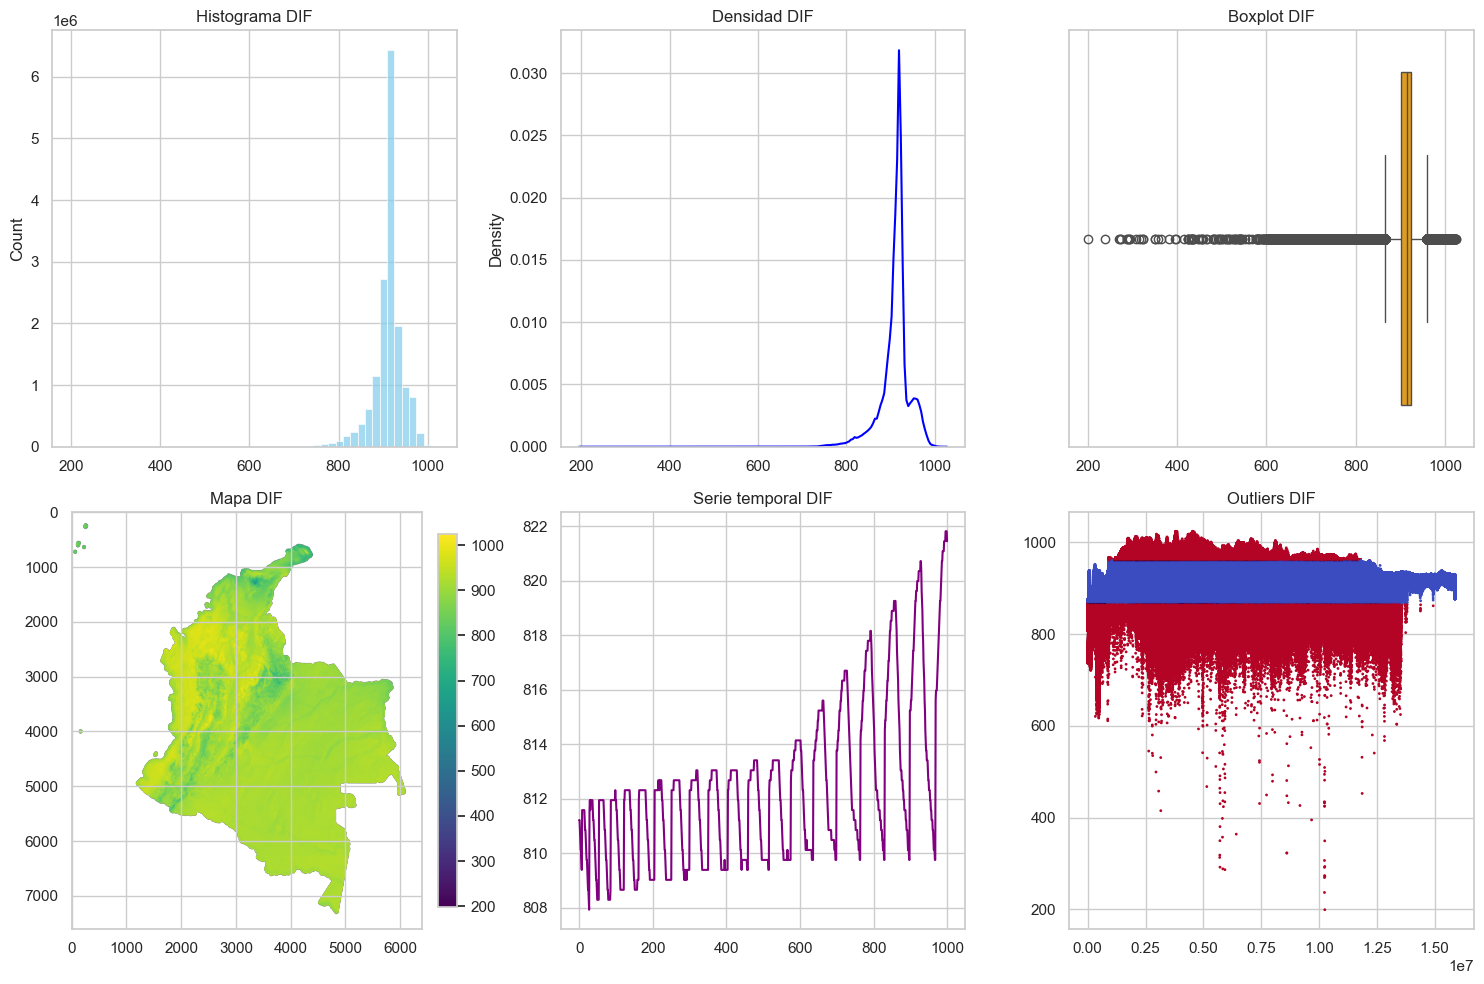

Variable: DNI - 15912584 valores válidos
   -> 11.13% de valores atípicos detectados


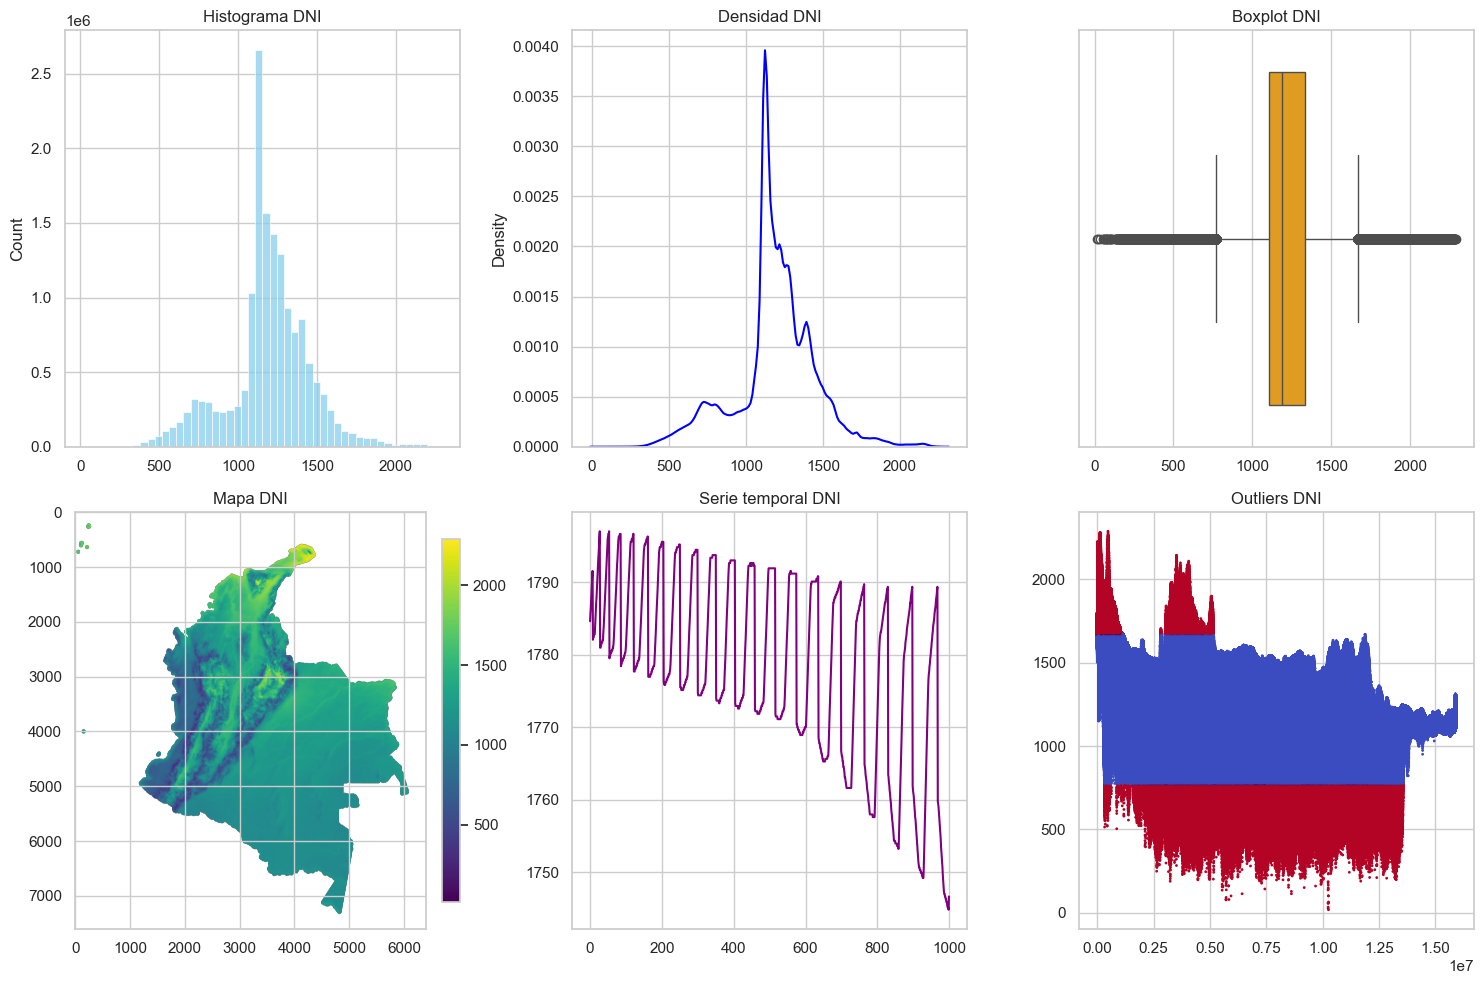

Variable: GHI - 15912584 valores válidos
   -> 10.40% de valores atípicos detectados


MemoryError: Unable to allocate 1.45 GiB for an array with shape (7600, 6400, 4) and data type float64

<Figure size 1500x1000 with 7 Axes>

Variable: GTI - 15912584 valores válidos
   -> 9.17% de valores atípicos detectados


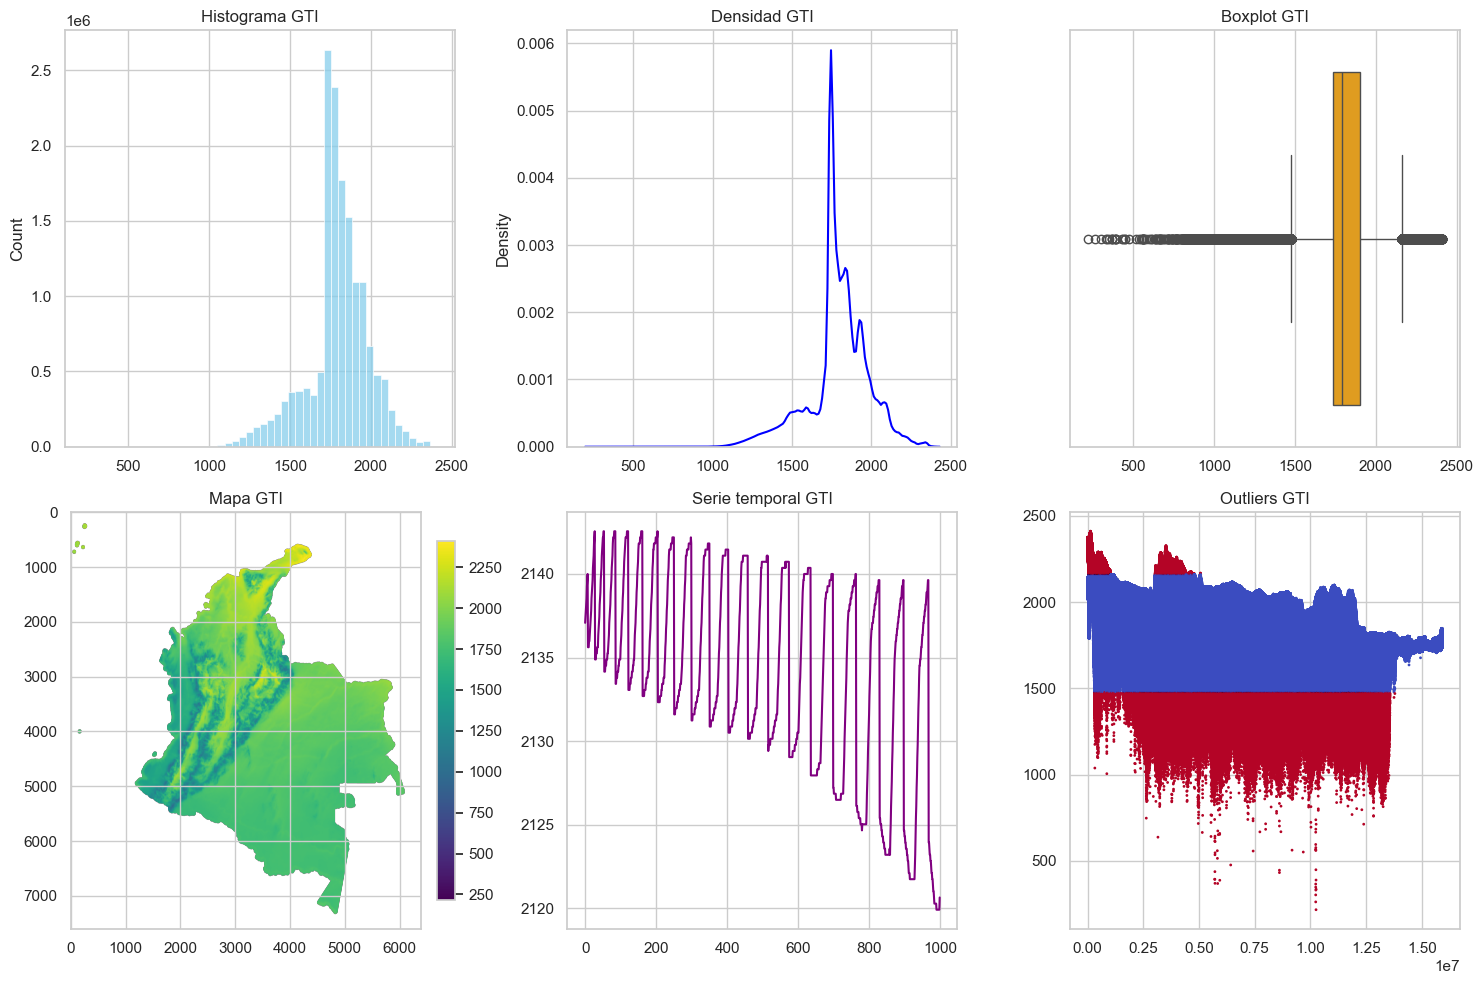

Variable: OPTA - 90681 valores válidos
   -> 0.00% de valores atípicos detectados


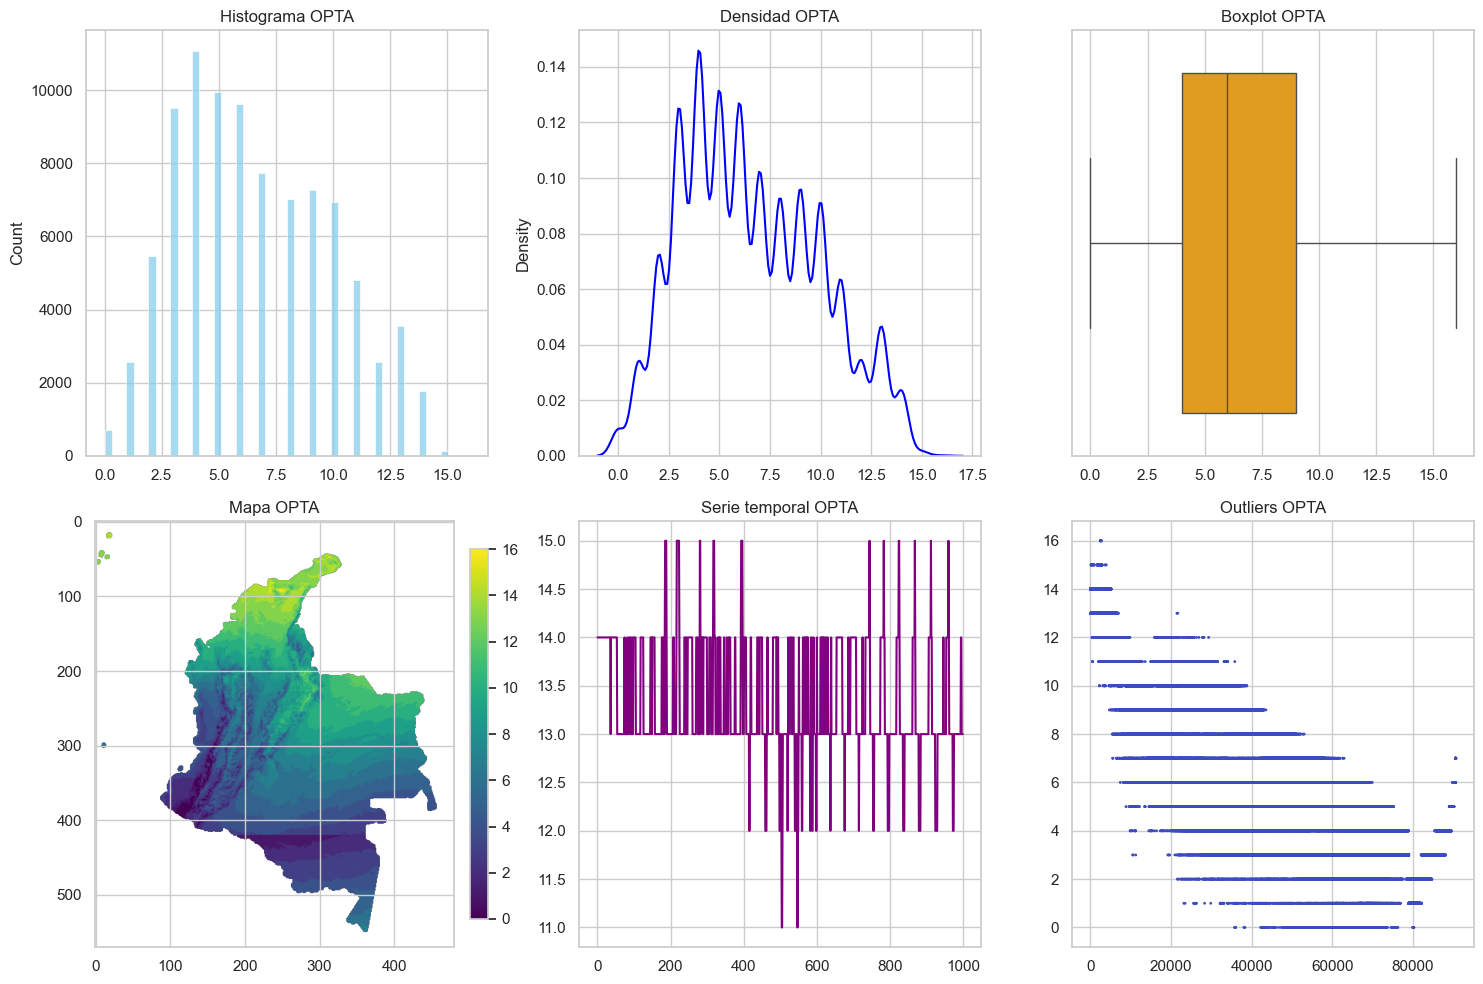

Variable: PVOUT - 1434988 valores válidos
   -> 8.23% de valores atípicos detectados


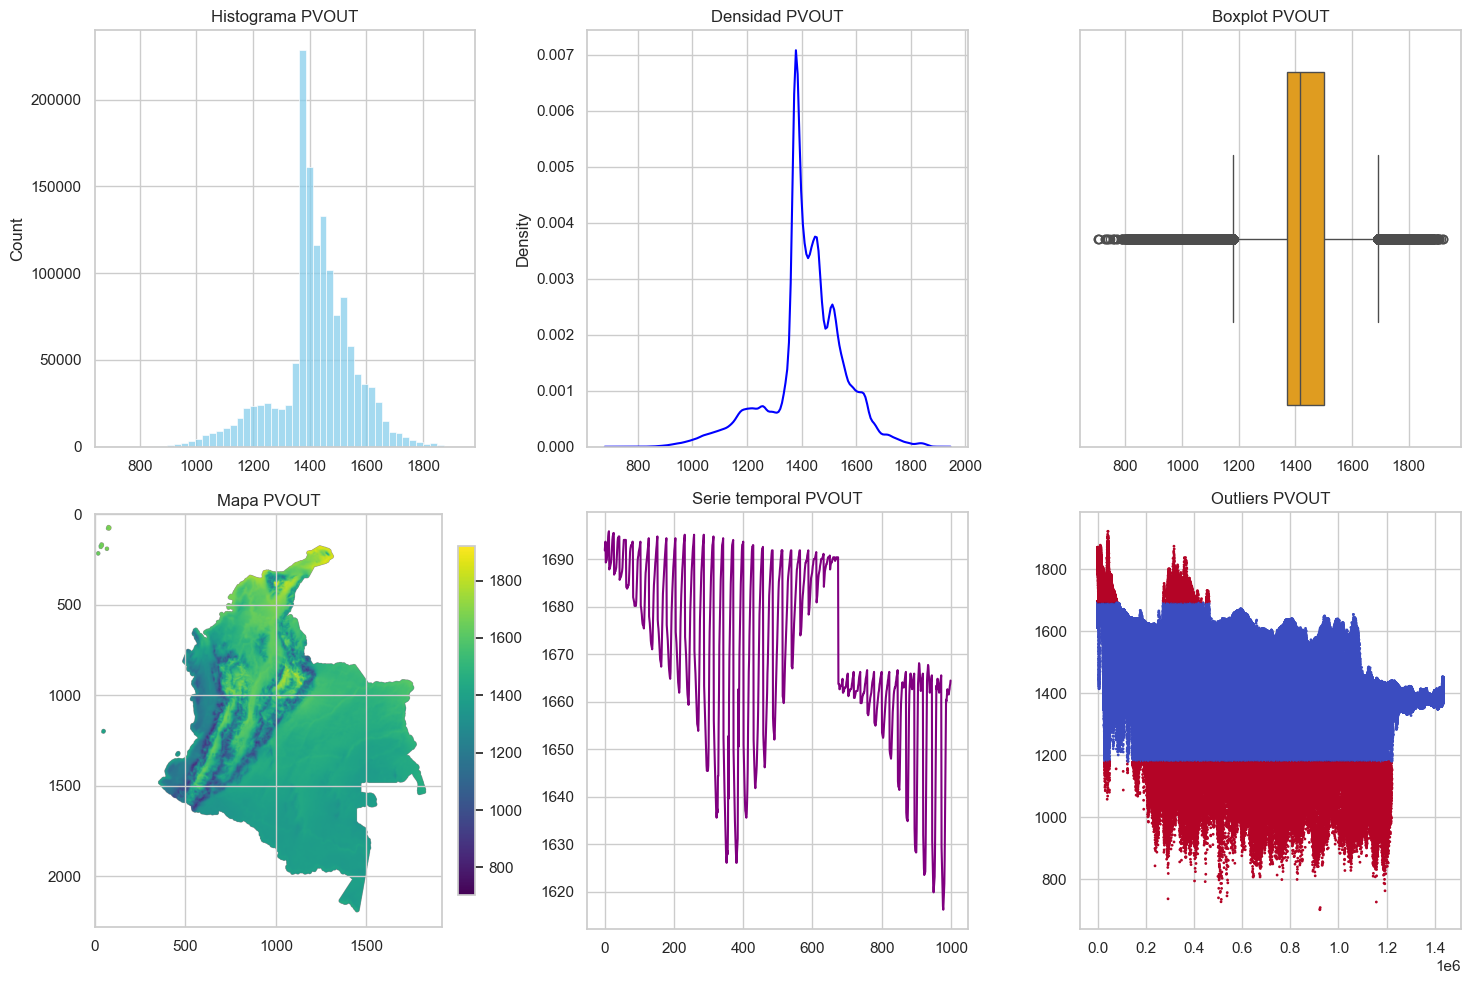

Variable: TEMP - 1436085 valores válidos
   -> 18.15% de valores atípicos detectados


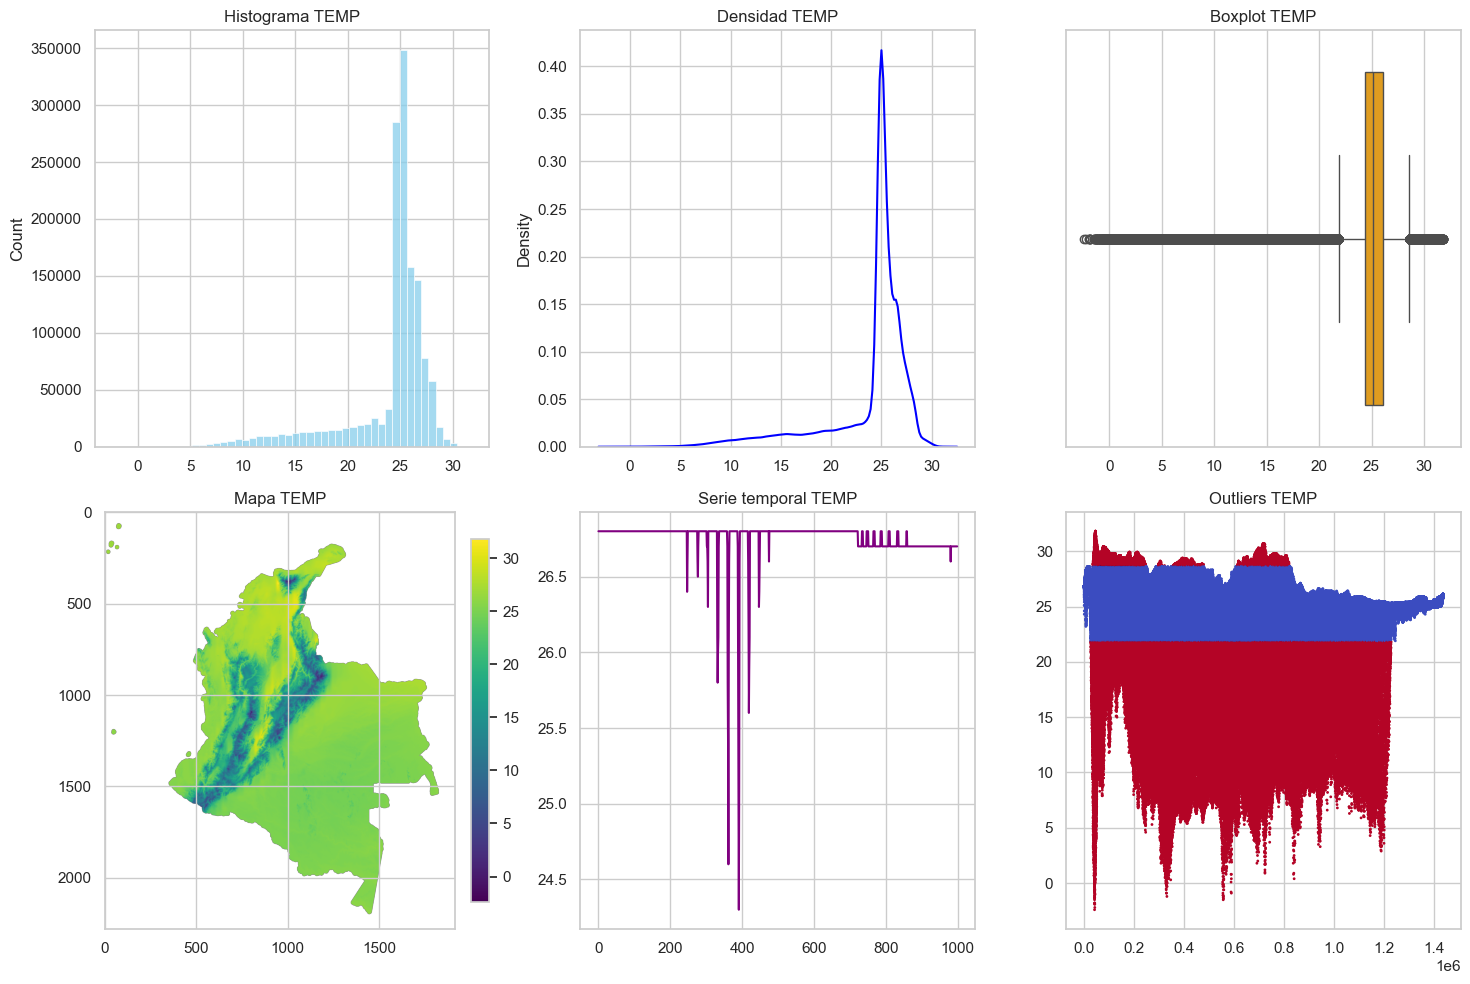

In [32]:

# Función para detectar outliers por IQR
def detect_outliers_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data < lower_bound) | (data > upper_bound)

# Diccionario para guardar resultados
data_dict = {}

# Leer y analizar cada variable
for var, filename in variables.items():
    filepath = os.path.join(data_path, filename)
    data = load_raster(filepath)
    data_dict[var] = data
    print(f"Variable: {var} - {len(data)} valores válidos")

    # Detectar outliers
    outliers = detect_outliers_iqr(data)
    perc_outliers = np.sum(outliers) / len(data) * 100
    print(f"   -> {perc_outliers:.2f}% de valores atípicos detectados")

    fig, axs = plt.subplots(2, 3, figsize=(15, 10))

    # Histograma
    sns.histplot(data, kde=False, ax=axs[0, 0], bins=50, color="skyblue")
    axs[0, 0].set_title(f"Histograma {var}")

    # KDE
    sns.kdeplot(data, ax=axs[0, 1], color="blue")
    axs[0, 1].set_title(f"Densidad {var}")

    # Boxplot
    sample_size = min(50000, len(data)) if var == "GHI" else len(data)
    data_box = np.random.choice(data, size=sample_size, replace=False) if var == "GHI" else data
    sns.boxplot(x=data_box, ax=axs[0, 2], color="orange")
    axs[0, 2].set_title(f"Boxplot {var} (muestra {sample_size})" if var == "GHI" else f"Boxplot {var}")

    # Serie temporal
    axs[1, 1].plot(data[:1000], color='purple')  # muestra 1000 puntos
    axs[1, 1].set_title(f"Serie temporal {var}")

    # Scatter con outliers
    axs[1, 2].scatter(range(len(data)), data, s=1, c=outliers, cmap="coolwarm")
    axs[1, 2].set_title(f"Outliers {var}")

    # Mapa raster 
    with rasterio.open(filepath) as src:
        raster_data = src.read(1).astype(float)
        raster_data[raster_data == src.nodata] = np.nan
        im = axs[1, 0].imshow(raster_data, cmap="viridis")
        axs[1, 0].set_title(f"Mapa {var}")
        plt.colorbar(im, ax=axs[1, 0], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

In [33]:
summary = {var: pd.Series(data).describe() for var, data in data_dict.items()}
summary_df = pd.DataFrame(summary)

In [34]:
df=data

In [35]:
summary_df

,DIF,DNI,GHI,GTI,OPTA,PVOUT,TEMP
count,1.591258e+07,1.591258e+07,1.591258e+07,1.591258e+07,90681.000000,1.434988e+06,1.436085e+06
mean,9.115020e+02,1.189355e+03,1.779310e+03,1.791023e+03,6.567892,1.418815e+03,2.393823e+01
std,3.283992e+01,2.585634e+02,1.806933e+02,1.891514e+02,3.340186,1.361090e+02,4.214888e+00
min,1.990610e+02,1.680200e+01,2.169580e+02,2.169580e+02,0.000000,7.023760e+02,-2.400000e+00
25%,9.014370e+02,1.104881e+03,1.730554e+03,1.733111e+03,4.000000,1.371879e+03,2.440000e+01
50%,9.160470e+02,1.185602e+03,1.783150e+03,1.790090e+03,6.000000,1.417900e+03,2.510000e+01
75%,9.248130e+02,1.330240e+03,1.885055e+03,1.903683e+03,9.000000,1.499716e+03,2.610000e+01
max,1.024161e+03,2.289752e+03,2.347096e+03,2.410285e+03,16.000000,1.922311e+03,3.180000e+01


In [36]:
data_dict

{'DIF': array([811.2199707 , 811.2199707 , 810.85498047, ..., 885.36602783,
        885.36602783, 886.09698486], shape=(15912584,)),
 'DNI': array([1784.61206055, 1785.70703125, 1786.43798828, ..., 1295.54199219,
        1294.08105469, 1294.81103516], shape=(15912584,)),
 'GHI': array([2083.38598633, 2084.1159668 , 2084.48193359, ..., 1833.18994141,
        1832.82495117, 1832.82495117], shape=(15912584,)),
 'GTI': array([2137.07788086, 2137.44311523, 2137.80810547, ..., 1843.41699219,
        1843.41699219, 1843.41699219], shape=(15912584,)),
 'OPTA': array([14., 14., 14., ...,  7.,  7.,  7.], shape=(90681,)),
 'PVOUT': array([1691.8380127 , 1692.93395996, 1693.66394043, ..., 1450.40795898,
        1451.13793945, 1451.50402832], shape=(1434988,)),
 'TEMP': array([26.79999924, 26.79999924, 26.79999924, ..., 26.10000038,
        26.10000038, 26.        ], shape=(1436085,))}

# Unir variables raster con municipios en un solo DataFrame


In [37]:
# Ruta al shapefile de municipios
shapefile_path = r"C:/Users/calex/OneDrive - Universidad de la Sabana/2025-2/UniSabana/Code - PCD/Municipios.shp"

# Leer shapefile manualmente con fiona
records = []
with fiona.open(shapefile_path) as src:
    for feat in src:
        props = feat["properties"]
        geom = shape(feat["geometry"])
        props["geometry"] = geom
        records.append(props)

# Convertir a DataFrame base
df_mun = pd.DataFrame(records)
print("Columnas disponibles en el shapefile:")
print(df_mun.columns)
print(df_mun.head())

# Columnas de interés
col_municipio = "MPIO_CNMBR"   # nombre de municipio
col_depto = "DEPTO"       # nombre de departamento

# Base inicial con municipio + depto
results = df_mun[[col_depto, col_municipio, "geometry"]].copy()

# Calcular estadísticas zonales por variable
for var, filename in variables.items():
    filepath = os.path.join(data_path, filename)
    print(f"Procesando {var} para municipios...")

    stats = zonal_stats(
        results["geometry"], filepath,
        stats=["mean", "median", "min", "max", "std"],
        nodata=np.nan
    )

    df_stats = pd.DataFrame(stats)
    df_stats = df_stats.add_prefix(f"{var}_") 
    results = pd.concat([results, df_stats], axis=1)

# Quitar geometría y renombrar columnas
df_final = pd.DataFrame(results.drop(columns="geometry"))
df_final = df_final.rename(columns={col_depto: "Departamento", col_municipio: "Municipio"})

# Guardar resultados en CSV
out_path = r"C:/Users/calex/OneDrive - Universidad de la Sabana/2025-2/UniSabana/Code - PCD/resultados_municipios.csv"
df_final.to_csv(out_path, index=False, encoding="utf-8-sig")

print(" DataFrame final con municipio y departamento creado")
print(df_final.head())



C:\Users\calex\AppData\Local\Temp\ipykernel_2760\1290979410.py:10: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  props["geometry"] = geom


Columnas disponibles en el shapefile:
Index(['DEPTO', 'DESCRPCION', 'DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR',
       'OBJECTID', 'OBJECTID_1', 'P_ACUENO', 'P_ACUESI', 'P_ALCANNO',
       'P_ALCANSI', 'P_ENERNO', 'P_ENERSI', 'P_GASNNO', 'P_GASNNOIN',
       'P_GASNSI', 'P_TELEFNO', 'P_TELEFNOI', 'P_TELEFSI', 'ShapeSTAre',
       'ShapeSTLen', 'Shape_Leng', 'geometry'],
      dtype='object')
     DEPTO    DESCRPCION DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR  \
0  CAQUETA  AREA # 18001         18        001               FLORENCIA   
1  CAQUETA  AREA # 18029         18        029                 ALBANIA   
2  CAQUETA  AREA # 18094         18        094  BELEN DE LOS ANDAQUIES   
3  CAQUETA  AREA # 18247         18        247             EL DONCELLO   
4  CAQUETA  AREA # 18256         18        256               EL PAUJIL   

   OBJECTID  OBJECTID_1  P_ACUENO  P_ACUESI  P_ALCANNO  ...  P_GASNNO  \
0        49           1      3876     26539       7789  ...     30415   
1        50     

In [38]:
# === Cargar datos (tu método actual, sin cambios) ===
data_dict = {}
for var, filename in variables.items():
    filepath = os.path.join(data_path, filename)
    data = load_raster(filepath)
    data_dict[var] = data
    print(f"Variable: {var} - {len(data)} valores válidos")

# === Leer shapefile manualmente con fiona (sin cambios) ===

records = []
with fiona.open(shapefile_path) as src:
    for feat in src:
        props = feat["properties"]
        geom = shape(feat["geometry"])
        props["geometry"] = geom
        records.append(props)

df_mun = pd.DataFrame(records)
print("Columnas disponibles en el shapefile:")
print(df_mun.columns)
print(df_mun.head())

# === Columnas de interés ===
col_municipio = "MPIO_CNMBR"
col_depto = "DEPTO"
results = df_mun[[col_depto, col_municipio, "geometry"]].copy()

# === Cálculo rápido y detallado de estadísticas zonales ===
# (Optimizado para terminar en menos de 30 min)
for var, filename in variables.items():
    filepath = os.path.join(data_path, filename)
    print(f"Procesando {var}...")

    stats = zonal_stats(
        results["geometry"],
        filepath,
        stats=["mean", "median", "min", "max", "std", "count"],
        nodata=np.nan,
        all_touched=False
    )

    df_stats = pd.DataFrame(stats)
    df_stats = df_stats.add_prefix(f"{var}_")
    results = pd.concat([results, df_stats], axis=1)

# === Crear resumen final ===
df_final = pd.DataFrame(results.drop(columns="geometry"))
df_final = df_final.rename(columns={col_depto: "Departamento", col_municipio: "Municipio"})

# === Guardar resultado ===
out_path = r"C:/Users/calex/OneDrive - Universidad de la Sabana/2025-2/UniSabana/Code - PCD/resultados_municipios_resumen.csv"
df_final.to_csv(out_path, index=False, encoding="utf-8-sig")

print("CSV con resumen estadístico por municipio creado correctamente.")
print(df_final.head())

Variable: DIF - 15912584 valores válidos
Variable: DNI - 15912584 valores válidos
Variable: GHI - 15912584 valores válidos
Variable: GTI - 15912584 valores válidos
Variable: OPTA - 90681 valores válidos
Variable: PVOUT - 1434988 valores válidos
Variable: TEMP - 1436085 valores válidos


C:\Users\calex\AppData\Local\Temp\ipykernel_2760\3266987736.py:16: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  props["geometry"] = geom


Columnas disponibles en el shapefile:
Index(['DEPTO', 'DESCRPCION', 'DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR',
       'OBJECTID', 'OBJECTID_1', 'P_ACUENO', 'P_ACUESI', 'P_ALCANNO',
       'P_ALCANSI', 'P_ENERNO', 'P_ENERSI', 'P_GASNNO', 'P_GASNNOIN',
       'P_GASNSI', 'P_TELEFNO', 'P_TELEFNOI', 'P_TELEFSI', 'ShapeSTAre',
       'ShapeSTLen', 'Shape_Leng', 'geometry'],
      dtype='object')
     DEPTO    DESCRPCION DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR  \
0  CAQUETA  AREA # 18001         18        001               FLORENCIA   
1  CAQUETA  AREA # 18029         18        029                 ALBANIA   
2  CAQUETA  AREA # 18094         18        094  BELEN DE LOS ANDAQUIES   
3  CAQUETA  AREA # 18247         18        247             EL DONCELLO   
4  CAQUETA  AREA # 18256         18        256               EL PAUJIL   

   OBJECTID  OBJECTID_1  P_ACUENO  P_ACUESI  P_ALCANNO  ...  P_GASNNO  \
0        49           1      3876     26539       7789  ...     30415   
1        50     

In [40]:
records = []
with fiona.open(shapefile_path) as src:
    for feat in src:
        props = feat["properties"]
        geom = shape(feat["geometry"])
        props["geometry"] = geom
        records.append(props)

df_mun = pd.DataFrame(records)
print("Columnas disponibles en el shapefile:")
print(df_mun.columns)
print(df_mun.head())

# === Columnas de interés ===
col_municipio = "MPIO_CNMBR"
col_depto = "DEPTO"
results = df_mun[[col_depto, col_municipio, "geometry"]].copy()

# === Cálculo rápido y detallado de estadísticas zonales ===
for var, filename in variables.items():
    filepath = os.path.join(data_path, filename)
    print(f"Procesando {var}...")

    stats = zonal_stats(
        results["geometry"],
        filepath,
        stats=["mean", "median", "min", "max", "std", "count"],
        nodata=np.nan,
        all_touched=False
    )

    df_stats = pd.DataFrame(stats)
    df_stats = df_stats.add_prefix(f"{var}_")
    results = pd.concat([results, df_stats], axis=1)

# ----------------------------------------------------------------------------------
# === CREAR RESUMEN FINAL CON COORDENADAS DE CENTROIDE (SOLUCIÓN FINAL) ===
# ----------------------------------------------------------------------------------

# 1. Convertir a GeoDataFrame y asignar el CRS WGS84 (EPSG:4326) de forma explícita.
#    Ya que el archivo .prj lo confirma, usamos el código EPSG:4326.
try:
    # Creamos el GeoDataFrame ASIGNANDO directamente el CRS conocido
    results_gdf = gpd.GeoDataFrame(
        results, 
        geometry='geometry', 
        crs="EPSG:4326" # <-- Asignación directa
    )

    # Si por alguna razón la geometría original estuviera en metros y no en grados, 
    # este paso la convertiría, pero el shapefile indica grados (Degree).
    # La reproyección solo se hace si el CRS NO ES 4326, pero como ya lo asignamos, se omite.
    # En este caso, no necesitamos reproyectar, solo garantizar la asignación.
    
except Exception as e:
    # Este error solo ocurre si hay problemas graves en la instalación o en los objetos 'geometry'
    print(f"ERROR CRÍTICO: No se pudo crear el GeoDataFrame. Revise geopandas/fiona. Detalle: {e}")
    # Podrías intentar una solución de respaldo
    results_gdf = gpd.GeoDataFrame(results, geometry='geometry')


# 2. Calcular la longitud (x) y latitud (y) del centroide
#    Al estar en WGS84, .x es Longitud (lon) y .y es Latitud (lat).
results_gdf['lon'] = results_gdf.geometry.centroid.x
results_gdf['lat'] = results_gdf.geometry.centroid.y

# 3. Crear el DataFrame final, renombrar y reordenar columnas
df_final = pd.DataFrame(results_gdf.drop(columns="geometry"))
df_final = df_final.rename(columns={col_depto: "Departamento", col_municipio: "Municipio"})

# Reordenar para que lat y lon estén al inicio
cols = ['Departamento', 'Municipio', 'lat', 'lon'] + [
    col for col in df_final.columns if col not in ['Departamento', 'Municipio', 'lat', 'lon']
]
df_final = df_final[cols]

# === Guardar resultado ===
out_path = r"C:/Users/calex/OneDrive - Universidad de la Sabana/2025-2/UniSabana/Code - PCD/resultados_municipios_resumen.csv"
df_final.to_csv(out_path, index=False, encoding="utf-8-sig")

print("\n------------------------------------------------------------------")
print("CSV con resumen estadístico y coordenadas de centroide creado correctamente.")
print("Las coordenadas están garantizadas en WGS84 (EPSG:4326).")
print("------------------------------------------------------------------")
print(df_final.head())

C:\Users\calex\AppData\Local\Temp\ipykernel_2760\3862016186.py:6: FionaDeprecationWarning: instances of this class -- CRS, geometry, and feature objects -- will become immutable in fiona version 2.0
  props["geometry"] = geom


Columnas disponibles en el shapefile:
Index(['DEPTO', 'DESCRPCION', 'DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR',
       'OBJECTID', 'OBJECTID_1', 'P_ACUENO', 'P_ACUESI', 'P_ALCANNO',
       'P_ALCANSI', 'P_ENERNO', 'P_ENERSI', 'P_GASNNO', 'P_GASNNOIN',
       'P_GASNSI', 'P_TELEFNO', 'P_TELEFNOI', 'P_TELEFSI', 'ShapeSTAre',
       'ShapeSTLen', 'Shape_Leng', 'geometry'],
      dtype='object')
     DEPTO    DESCRPCION DPTO_CCDGO MPIO_CCDGO              MPIO_CNMBR  \
0  CAQUETA  AREA # 18001         18        001               FLORENCIA   
1  CAQUETA  AREA # 18029         18        029                 ALBANIA   
2  CAQUETA  AREA # 18094         18        094  BELEN DE LOS ANDAQUIES   
3  CAQUETA  AREA # 18247         18        247             EL DONCELLO   
4  CAQUETA  AREA # 18256         18        256               EL PAUJIL   

   OBJECTID  OBJECTID_1  P_ACUENO  P_ACUESI  P_ALCANNO  ...  P_GASNNO  \
0        49           1      3876     26539       7789  ...     30415   
1        50     

C:\Users\calex\AppData\Local\Temp\ipykernel_2760\3862016186.py:64: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  results_gdf['lon'] = results_gdf.geometry.centroid.x
C:\Users\calex\AppData\Local\Temp\ipykernel_2760\3862016186.py:65: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  results_gdf['lat'] = results_gdf.geometry.centroid.y


In [41]:
df_final

,Departamento,Municipio,lat,lon,DIF_min,DIF_max,DIF_mean,DIF_count,DIF_std,DIF_median,...,PVOUT_mean,PVOUT_count,PVOUT_std,PVOUT_median,TEMP_min,TEMP_max,TEMP_mean,TEMP_count,TEMP_std,TEMP_median
0,CAQUETA,FLORENCIA,1.749139,-75.558237,802.818970,958.051025,909.802163,33098,13.177103,912.393982,...,1267.520987,2978,99.337954,1262.303955,8.200000,25.400000,20.056479,2978,4.179916,20.700001
1,CAQUETA,ALBANIA,1.227875,-75.882333,918.604004,928.466003,923.025512,5370,1.862814,922.622009,...,1395.313789,485,5.980074,1395.985962,23.600000,25.100000,24.457527,485,0.362935,24.500000
2,CAQUETA,BELEN DE LOS ANDAQUIES,1.500935,-75.875653,822.543030,951.841980,915.903580,15474,13.474749,918.968994,...,1291.264843,1398,103.444745,1320.014038,10.000000,25.000000,20.928040,1398,3.178867,21.799999
3,CAQUETA,EL DONCELLO,1.791381,-75.193941,815.603027,945.267029,907.085480,14366,16.761201,913.125000,...,1336.953101,1298,122.206388,1413.151978,7.800000,25.600000,21.758011,1298,4.399175,24.600000
4,CAQUETA,EL PAUJIL,1.617748,-75.234042,803.549988,936.866028,910.789359,16051,15.457376,916.411987,...,1355.611419,1445,119.271516,1415.343994,7.700000,25.600000,22.417579,1445,4.670324,25.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,CUNDINAMARCA,FUSAGASUGA,4.323540,-74.388584,762.642029,953.302002,929.391227,2519,24.501736,937.596985,...,1271.111784,227,137.676686,1308.691040,15.300000,28.299999,23.106609,227,2.403485,23.500000
1114,CUNDINAMARCA,SAN JUAN DE RIO SECO,4.841096,-74.658499,837.518005,963.164001,932.363348,4098,11.773004,931.752991,...,1447.188342,371,79.777684,1442.371948,17.700001,27.100000,23.767657,371,2.339392,24.400000
1115,TOLIMA,HONDA,5.179419,-74.783032,874.408020,937.231995,918.366851,3973,8.984192,920.065002,...,1601.534280,361,10.131719,1601.987061,22.100000,26.400000,24.539612,361,0.811796,24.600000
1116,ANTIOQUIA,SABANETA,6.138325,-75.608803,906.916016,948.919983,926.497757,209,6.118261,925.908997,...,1475.610064,17,30.861511,1480.723999,16.900000,20.700001,19.300000,17,1.176235,19.600000


In [42]:
df_final = df_final.sort_values(by='Municipio')
df_final = df_final.reset_index(drop=True)
df_final    

,Departamento,Municipio,lat,lon,DIF_min,DIF_max,DIF_mean,DIF_count,DIF_std,DIF_median,...,PVOUT_mean,PVOUT_count,PVOUT_std,PVOUT_median,TEMP_min,TEMP_max,TEMP_mean,TEMP_count,TEMP_std,TEMP_median
0,ANTIOQUIA,ABEJORRAL,5.803732,-75.438475,754.606018,929.560974,881.074653,6624,18.158807,880.252014,...,1576.275506,593,46.818488,1580.072021,11.800000,26.100000,17.796458,593,3.629828,16.799999
1,NORTE DE SANTANDER,ABREGO,8.019840,-73.158500,743.648987,959.877014,885.606144,18131,22.414293,882.443970,...,1485.635334,1633,126.278076,1511.038940,9.100000,28.500000,17.773239,1633,3.095812,17.799999
2,ANTIOQUIA,ABRIAQUI,6.627566,-76.085974,772.504028,943.075989,895.308542,3869,19.161597,897.054016,...,1364.816761,352,69.255554,1365.304443,10.900000,20.400000,16.126420,352,1.939046,16.400000
3,META,ACACIAS,4.009642,-73.723908,520.481018,944.536011,895.008265,14640,29.089775,905.090027,...,1330.402599,1318,159.899431,1412.969482,4.900000,25.000000,18.983382,1318,5.387996,20.600000
4,Choco,ACANDI,8.434201,-77.289679,863.450989,967.546997,935.564880,10450,12.986824,936.866028,...,1288.955319,940,108.242284,1307.777466,18.400000,26.900000,25.385426,940,1.542466,26.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1113,VALLE DEL CAUCA,ZARZAL,4.353597,-76.050654,897.054016,956.955017,928.454071,4790,16.581955,931.388000,...,1597.008601,436,31.584202,1601.255981,21.600000,23.600000,22.341055,436,0.272413,22.400000
1114,BOYACA,ZETAQUIRA,5.285630,-73.167629,794.783997,914.585999,882.054215,3274,16.057744,883.905029,...,1237.947704,294,103.464200,1231.257568,7.200000,19.299999,13.781293,294,2.878768,13.750000
1115,CUNDINAMARCA,ZIPACON,4.754323,-74.386739,817.794983,954.398010,924.721004,707,20.058958,929.195984,...,1191.057373,64,59.130795,1179.027100,12.300000,22.900000,16.364063,64,2.460079,15.800000
1116,CUNDINAMARCA,ZIPAQUIRA,5.046195,-74.023070,821.081970,912.760010,889.473819,2540,12.176006,892.853516,...,1375.974893,234,49.759913,1370.417969,9.400000,15.800000,13.111966,234,1.904680,13.150000
